In [1]:
from collections import Counter
import csv
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.sql.functions import isnan, when, count, col, collect_list
import random
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, mean_absolute_error
import xgboost as xgb

Init PySpark and Dataset

In [2]:
spark = pyspark.sql.SparkSession.builder.appName('Wine Quality').getOrCreate()

In [3]:
data = spark.read.csv('../Datasets/winequality-red.csv', sep=';', inferSchema=True, header=True)

In [4]:
data.toPandas().head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Analysis

Missing Values

In [5]:
nans = data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas().transpose()
nans.columns = ['Number of missing']
nans

,Number of missing
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


Number of values

In [6]:
for c in data.columns:
    print(c + ':', str(len(set(list(data.select(collect_list(c)).first()[0])))) + ' unique values')

fixed acidity: 96 unique values
volatile acidity: 143 unique values
citric acid: 80 unique values
residual sugar: 91 unique values
chlorides: 153 unique values
free sulfur dioxide: 60 unique values
total sulfur dioxide: 144 unique values
density: 436 unique values
pH: 89 unique values
sulphates: 96 unique values
alcohol: 65 unique values
quality: 6 unique values


Class Distribution

In [7]:
classes = data.select(collect_list('quality')).first()[0]
class_counter = Counter(classes)
class_dist = [class_counter[key] for key in class_counter.keys()]

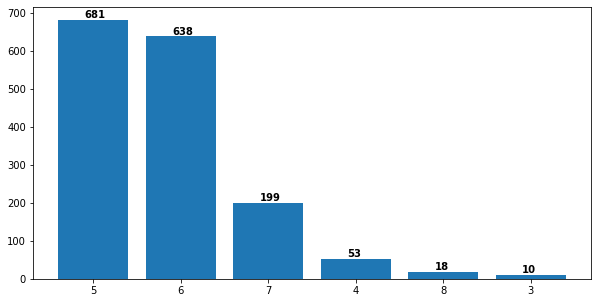

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([str(el) for el in class_counter.keys()], class_dist)
for i, v in enumerate(class_dist):
    ax.text(i - 0.1, v + 5, str(v), fontweight='bold')
plt.show()

Map Outputs

In [9]:
set(list(data.select(collect_list('quality')).first()[0]))

{3, 4, 5, 6, 7, 8}

In [10]:
data = data.withColumn('quality', data['quality'] - 3)

In [11]:
set(list(data.select(collect_list('quality')).first()[0]))

{0, 1, 2, 3, 4, 5}

Train-Test Split

In [12]:
train, test = data.randomSplit([0.85, 0.15], seed=42)

In [13]:
x_train, y_train = train.select(data.columns[:-1]), train.select(data.columns[-1])
x_test, y_test = test.select(data.columns[:-1]), test.select(data.columns[-1])
x_train = x_train.toPandas().values
y_train = y_train.toPandas().values.flatten()
x_test = x_test.toPandas().values
y_test = y_test.toPandas().values.flatten()

Train XGboost Classifier

In [14]:
D_train = xgb.DMatrix(x_train, label=y_train)
D_test = xgb.DMatrix(x_test, label=y_test)

In [15]:
def train_xgb_classifier(eta, dp, n_class, steps, d_train, d_test):
    params = {'eta': eta, 
        'max_depth': dp,
        'eval_metric': 'mlogloss',
        'num_class': n_class
    }
    
    model = xgb.train(params, d_train, steps)
    preds = model.predict(d_test)
    return round(recall_score(preds, y_test, average='micro'), 4)

In [16]:
num_class = len(set(list(data.select(collect_list('quality')).first()[0])))

all_etas = [0.10, 0.15, 0.20, 0.25, 0.30]
all_depths = [2, 3, 4, 5, 6, 7]
all_steps = [10, 15, 20, 25, 30, 40, 50, 75, 100]

perfs = np.zeros((len(all_etas), len(all_depths), len(all_steps)))

# Grid search over eta, max_depth and step parameters
for i in range(len(all_etas)):
    for j in range(len(all_depths)):
        for k in range(len(all_steps)):
            perfs[i, j, k] = train_xgb_classifier(all_etas[i], all_depths[j], num_class, all_steps[k], D_train, D_test)

# Find optimal set of parameters (maximizes recall)
best_eta, best_depth, best_steps = np.where(perfs == perfs.max())
best_eta = best_eta[0]
best_depth = best_depth[0]
best_steps = best_steps[0]

print('Best eta:', all_etas[best_eta])
print('Best max_depth:', all_depths[best_depth])
print('Best number of steps:', all_steps[best_steps])
print('Recall:', perfs.max())

Best eta: 0.25
Best max_depth: 4
Best number of steps: 50
Recall: 0.6847


Random Forest Classifier

In [17]:
rf_perfs = []
all_rf_depths = [i for i in range(1, 10)]
for depth in all_rf_depths:
    rf = RandomForestClassifier(max_depth=depth, random_state=42)
    rf.fit(x_train, y_train)
    rf_preds = rf.predict(x_test)
    rf_perfs.append(round(recall_score(rf_preds, y_test, average='micro'), 4))

In [18]:
print('Best recall:', max(rf_perfs), '(max_depth of ' + str(all_rf_depths[rf_perfs.index(max(rf_perfs))]) + ')')

Best recall: 0.67 (max_depth of 9)


In [19]:
spark.stop()